# Plot nitrate discharge figure
Plot comparison between observed and Cycles-L predicted nitrate discharge at the WE-38 watershed.
This Jupyter notebook requires the `PIHM-utils` Python package.

## Import and set plotting parameters

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from my_funcs import nse
from pihm import read_output
from setting import WE38_WATER_QUALITY_OBS, WE38_DISCHARGE_OBS

In [2]:
SMALL_SIZE = 14
MEDIUM_SIZE = SMALL_SIZE + 2
BIGGER_SIZE = MEDIUM_SIZE + 2

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Read observations

In [3]:
# Read observed N concentrations
conc_obs_df = pd.read_csv(
    WE38_WATER_QUALITY_OBS,
    header=0,
    usecols=[1, 2],
    names=['date', 'conc'],
    parse_dates=['date'],
)
conc_obs_df.sort_values('date', inplace=True)
conc_obs_df.set_index('date', inplace=True)
conc_obs_df.dropna(inplace=True)

# Read observed discharge
q_obs_df = pd.read_csv(
    WE38_DISCHARGE_OBS,
    delimiter=',',
    skipinitialspace=True,
    usecols=[1, 2],
    header=0,
    names=['date', 'q'],
    parse_dates=['date'],
)
q_obs_df.sort_values('date', inplace=True)
q_obs_df.set_index('date', inplace=True)
# Calculate 7-day mean
q_obs_df = q_obs_df.rolling('7d', min_periods=3, center=True, win_type=None).mean()
q_obs_df.dropna(inplace=True)

leaching_obs_df = q_obs_df.join(conc_obs_df, how='inner')
leaching_obs_df['leaching'] = leaching_obs_df['q'] * leaching_obs_df['conc'] * 86400.0 * 1.0E-3 # convert to kg day-1
leaching_obs_df['doy'] = leaching_obs_df.index.dayofyear

# Read output and plot

observed: 31.159009
WE38 NSE 0.6024231411609257
21.58940201635205
WE38_1dot25xN NSE 0.6082155644478893
28.35432524891038


Text(0.675, 0.52, '(d)')

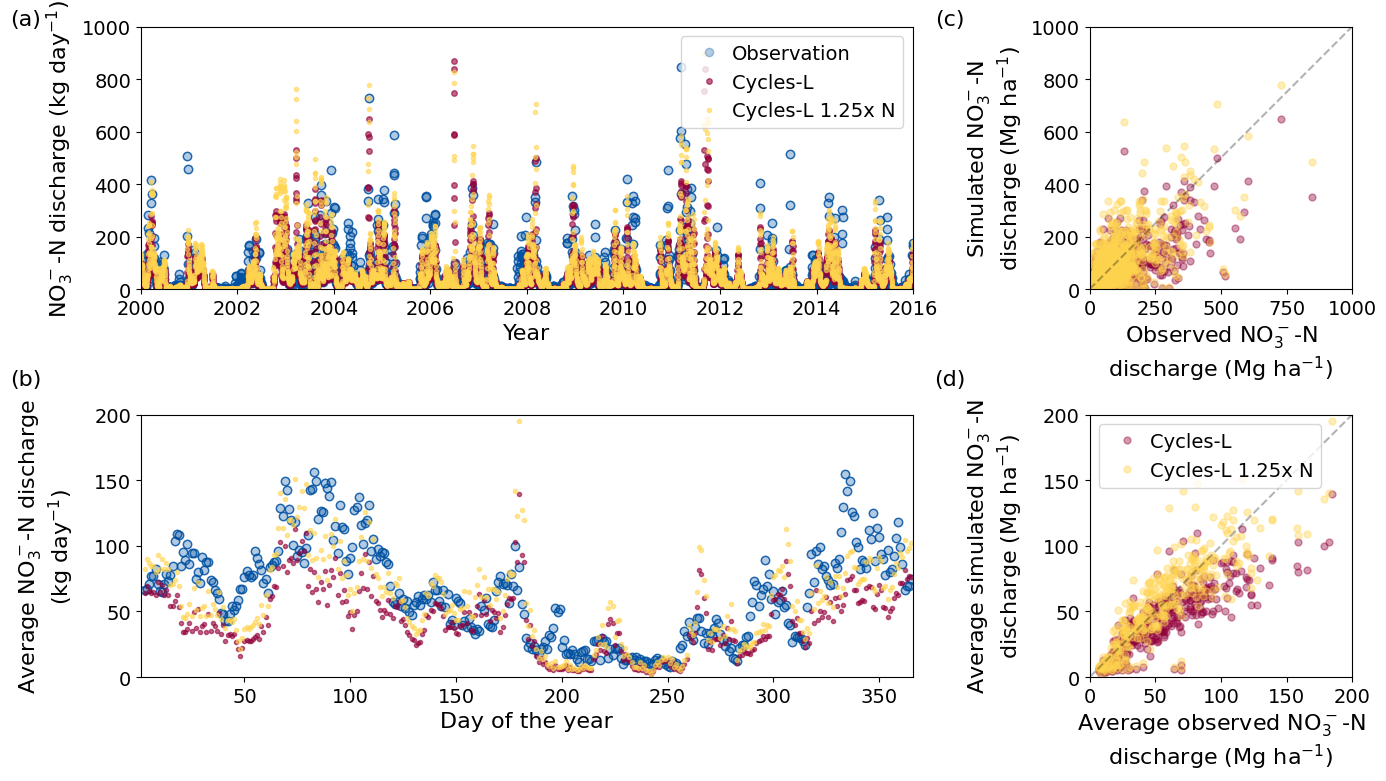

In [4]:
scenarios = {
    "WE38": ["", "#93003a", 8],
    "WE38_1dot25xN": ["1.25x N", "#ffd44f", 6],
}

fig = plt.figure(figsize=(14, 8))

axs = []
axs.append(fig.add_subplot(2, 3, (1, 2)))
axs.append(fig.add_subplot(2, 3, (4, 5)))
axs.append(fig.add_subplot(2, 3, 3))
axs.append(fig.add_subplot(2, 3, 6))
lines = []
dots = []

axs[0].plot(
    leaching_obs_df.index, leaching_obs_df['leaching'],
    'o',
    color="#0051a2",
    mfc='none',
    alpha=0.8,
    label='Observation'
)
_line, = axs[0].plot(
    leaching_obs_df.index, leaching_obs_df['leaching'],
    'o',
    color="#0051a2",
    alpha=0.3,
    label='Observation'
)
lines.append(_line)

leaching_doy_df = leaching_obs_df.groupby(leaching_obs_df['doy']).mean()
print("observed: %f" % (leaching_doy_df.sum()["leaching"] / 741.6))
leaching_doy_df = leaching_doy_df.rolling(3, min_periods=3, center=True, win_type=None).mean()
axs[1].plot(
    leaching_doy_df.index,
    leaching_doy_df['leaching'],
    'o',
    color="#0051a2",
    mfc='none',
    alpha=0.8,
    label='Observation')
axs[1].plot(
    leaching_doy_df.index,
    leaching_doy_df['leaching'],
    'o',
    color="#0051a2",
    alpha=0.3,
    label='Observation')
for scene in scenarios:
    sim_time, _n_mass, _, unit = read_output('..', 'WE38', scene, 'river.NO3')
    sim_time, _stage, _, _ = read_output('..', 'WE38', scene, 'river.stage')
    sim_time, _q, _, _ = read_output('..', 'WE38', scene, 'river.flx1')
    sim_time -= timedelta(days=1)

    simulation = pd.DataFrame({'q': _q[:, 0], 'date': sim_time})
    simulation.set_index('date', inplace=True)
    # Calculate 7-day mean
    simulation = simulation.rolling('7d', min_periods=3, center=True, win_type=None).mean()
    simulation['mass'] = _n_mass[:, 0]
    simulation['stage'] = _stage[:, 0]
    simulation['conc'] = simulation['mass'] / simulation['stage'] * 100.0
    simulation['leaching'] = simulation['q'] * simulation['conc'] * 86400.0 * 1.0E-3

    merged = leaching_obs_df.join(simulation, how='inner', lsuffix='_obs', rsuffix='_sim')
    _dot, = axs[2].plot(merged["leaching_obs"], merged["leaching_sim"],
        "o",
        color=scenarios[scene][1],
        ms=5,
        alpha=0.4,
        label='Cycles-L ' + scenarios[scene][0],
    )
    dots.append(_dot)
    print(scene, 'NSE', nse(merged['leaching_obs'], merged['leaching_sim']))
    merged = merged.groupby(merged['doy']).mean()
    print(merged.sum()["leaching_sim"] / 741.6)
    merged = merged.rolling(3, min_periods=3, center=True, win_type=None).mean()
    axs[3].plot(merged["leaching_obs"], merged["leaching_sim"],
        "o",
        color=scenarios[scene][1],
        ms=5,
        alpha=0.4,
        label=scenarios[scene][0]
    )

    _line, = axs[0].plot(simulation.index, simulation['leaching'],
        '.',
        color=scenarios[scene][1],
        ms=scenarios[scene][2],
        #mfc='none',
        alpha=0.6,
        label='Cycles-L ' + scenarios[scene][0],
    )
    lines.append(_line)

    axs[1].plot(merged.index, merged['leaching_sim'],
        '.',
        color=scenarios[scene][1],
        #mfc='none',
        alpha=0.6,
    )

# Set x and y axis labels
axs[0].set_xlabel('Year')
axs[0].set_ylabel('NO$_3^-$-N discharge (kg day$^{-1}$)')

### Clean up the x axis dates
axs[0].set_ylim(0, 1000)
axs[0].set_xlim(datetime(2000, 1, 1), datetime(2016, 1, 1))
axs[0].xaxis.set_major_locator(mdates.YearLocator(2))
axs[0].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

# Set x and y axis labels
axs[1].set_xlabel('Day of the year')
axs[1].set_ylabel('Average NO$_3^-$-N discharge\n(kg day$^{-1}$)')

axs[1].set_ylim(0, 200)
axs[1].set_xlim([1, 366])

axs[0].legend(
        handles=lines,
        loc='upper right',
        handletextpad=0.2,
        ncol=1,
    )
axs[3].legend(
        handles=dots,
        loc='upper left',
        handletextpad=0.2,
    )
axs[2].plot([0, 2000], [0, 2000], 'k--', alpha=0.3)
# Set x and y axis labels
axs[2].set_xlabel('Observed NO$_3^-$-N\ndischarge (' + unit + ')')
axs[2].set_ylabel('Simulated NO$_3^-$-N\ndischarge (' + unit + ')')

## Clean up the x axis dates
axs[2].set_ylim(0, 1000)
axs[2].set_xlim(0, 1000)
axs[2].set_aspect("equal")

axs[3].plot([0, 1000], [0, 1000], 'k--', alpha=0.3)
axs[3].set_xlabel('Average observed NO$_3^-$-N\ndischarge (' + unit + ')')
axs[3].set_ylabel('Average simulated NO$_3^-$-N\ndischarge (' + unit + ')')
axs[3].set_ylim(0, 200)
axs[3].set_xlim(0, 200)
axs[3].set_aspect("equal")

plt.tight_layout()
fig.align_ylabels(axs)

fig.text(0.015, 0.97,'(a)', ha='center', va='center', transform=fig.transFigure)
fig.text(0.675, 0.97,'(c)', ha='center', va='center', transform=fig.transFigure)
fig.text(0.015, 0.52,'(b)', ha='center', va='center', transform=fig.transFigure)
fig.text(0.675, 0.52,'(d)', ha='center', va='center', transform=fig.transFigure)

#fig.savefig("n_leaching.pdf", dpi=300)
#fig.savefig("n_leaching.png", dpi=300)
